<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [19]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Additional libraries 
import pickle

Reading original data

In [9]:
train_df = pd.read_csv('../../data/websites_train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('../../data/websites_test_sessions.csv', index_col='session_id')

Separate target feature (AFTER SORTING!!!)

In [32]:
y = train_df['target']

### Let's repeat old steps from Assignmet №4

In [16]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head(3)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0


The training dataset contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, value 1 for Alice's sessions, and 0 otherwise
    
User sessions are chosen in such a way that they are no longer than half an hour and/or contain more than ten websites i.e. a session is considered ended if either a user has visited ten websites or a session has lasted for more than thirty minutes.

There are some empty values in the table, which means that these sessions contain less than ten websites. Replace empty values with 0, and change the columns' types to integer. Load the website's dictionary and see what it looks like:

In [20]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


Let's check which websites in the training data set are the most visited. As you can see, they are Google services and a bioinformatics website (a website with 'zero'-index is our missed values, just ignore it):

In [21]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.index.tolist()]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
0,NaN
23,www.google.com
782,annotathon.org
22,apis.google.com


In [22]:
# Top Alice's websites in the training data set
a_df = train_df[train_df['target']==1]
a_top_sites = pd.Series(a_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(20)
print(a_top_sites)
sites_dict.loc[a_top_sites.index.tolist()]

77      1382
80      1354
76      1307
29       897
21       857
81       609
879      522
22       522
75       451
82       447
23       437
35       381
881      371
37       293
33       291
3000     286
733      274
30       272
78       236
941      215
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


What kind of websites does Alice visit the most? => videohostings

Now, let us look at the timestamps and try to characterize sessions by timeframes:

In [23]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


Additional notes: 

- on average, Alice's session is shorter than other users'one 

In [25]:
time_df[time_df['target'] == 1]['seconds'].mean(), time_df[time_df['target'] == 0]['seconds'].mean()

(52.29647366129734, 139.28237232552215)

In order to train our first model, we need to prepare the data. First, exclude the target variable from the training set. Both training and test sets now have the same number of columns, and we can aggregate them into a single dataframe. All transformations will therefore be performed simultaneously on both training and test data sets.

On the one hand, this will lead to the fact that both data sets have one feature space (you don't have to worry that you forgot to transform a feature in some data sets). On the other hand, processing time will increase. For enormously large sets, it might be impossible to transform both data sets simultaneously, and you willhave to split your transformations into several stages across the train/test data set). For this dataset, we are going to perform all the transformations for the whole combined dataframe at once and will filter the appropriate part before training the model or making predictions.

In [26]:
# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

For the basic model, we will use only the visited websites in the session (but will not take into account the timestamp features). The point behind this data selection is: *Alice has her favorite sites. The more often you see these sites in the session, the higher the probability that this is Alice and vice versa.*

Now we'll prepare the data, taking only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values have been replaced with zero. Here is how the first rows of the dataframe should look:

In [27]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Sessions are the sequences of website indices. This representation is inconvenient for linear methods. According to our hypothesis (Alice has favorite websites), we need to transform this dataframe so that each website has its corresponding feature (column) and that its value is equal to number of visits in the session. It can be accomplished with two lines of code:

In [28]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

###  Training the first model

We have an algorithm and data for it. Let's build our first model using the [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from ` sklearn` with default parameters. We will use the first 90% of the data for training (sorted by time) and the remaining 10% for validation. Let's write a simple function that returns the quality of the model and then train our first classifier:

In [29]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [33]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y))

0.919524558715
Wall time: 4.99 s


The first model achieved an accuracy of 0.91952 on the validation set. The will be the first baseline and starting point. To make a prediction on the test data set, ** we need to train the model again on the entire training dataset ** Up until now, our model used only part of the data for training; this will now increase its generalizing ability:

In [34]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [36]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

### Model Improvement: New Features Engineering

Now we are going to try to improve the quality of our model by adding new features to the data.

In [46]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

In [47]:
full_new_feat['n_unique_sites'] = full_df[sites].nunique(axis=1)

In [48]:
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
full_new_feat['morning'] = full_df['time1'].apply(lambda ts: 1 if ts.hour <= 11 else 0)

full_new_feat.tail(5)

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
82793,201410,4,18,0
82794,201405,6,14,0
82795,201405,10,11,1
82796,201405,7,10,1
82797,201411,2,10,1


In [50]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y)
print(score_C_1)

0.959153723389


###  Regularization Parameter Tuning

We have introduced features that improve the quality of our model in comparison with the first baseline. Can we do even better? After we have formed the training and test sets, it almost always makes sense to search for the optimal hyperparameters - the parameters of the model that do not change during training.

For example, in week 3, in decision trees, the depth of the tree is a hyperparameter, but the feature by which splitting occurs and its threshold is not. 

In the logistic regression we use, the weights of each feature are changing, and we find their optimal values during training; meanwhile, the regularization parameter remains constant. This is the hyperparameter that we are going to optimize now.

We will try to beat this result by optimizing the regularization parameter. We will take a list of possible values of $C$ and calculate the quality metric on the validation set for each of $C$-values:

In [52]:
%%time
# List of possible C-values
Cs = np.logspace(-3, 1, 10)

scores = []
    
for C in Cs:
    scores.append(get_auc_lr_valid(X_train, y, C=C))

Wall time: 41.9 s


Plot the graph of the quality metric (AUC-ROC) versus the value of the regularization parameter. The value of quality metric corresponding to the default value of C=1 is represented by a horizontal dotted line:

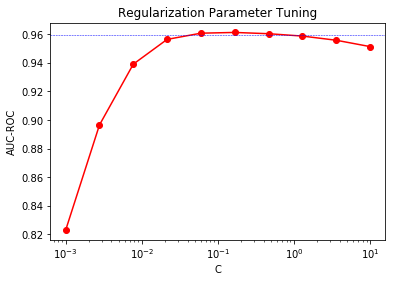

In [53]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

In [54]:
C_opt = Cs[scores.index(max(scores))]
C_opt

0.1668100537200059

Train the model using the optimal regularization parameter we found (0.92784 on the public leaderboard on Kaggle)

In [57]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C_opt, random_state=17).fit(X_train, y)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Capture the quality with optimized parameters
score_C_opt = get_auc_lr_valid(X_train, y, C=C_opt)
print(score_C_opt)

0.961212510688


In [58]:
# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2.csv')

### Let's do new steps for Assignmet №6

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [78]:
# You code here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,1))

In [74]:
full_new_feat['all_sites'] = \
full_sites['site1'].map(str) + ' ' + \
full_sites['site2'].map(str) + ' ' + \
full_sites['site3'].map(str) + ' ' + \
full_sites['site4'].map(str) + ' ' + \
full_sites['site5'].map(str) + ' ' + \
full_sites['site6'].map(str)

In [85]:
bag_of_sites = vectorizer.fit_transform(full_new_feat['all_sites'])

# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],  bag_of_sites[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:],  bag_of_sites[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C_opt, random_state=17).fit(X_train, y)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Capture the quality with optimized parameters
score_C_opt = get_auc_lr_valid(X_train, y, C=C_opt)
print(score_C_opt)

0.960998449947


We see that score decreases. Let's find new C_opt

In [86]:
%%time
# List of possible C-values
Cs = np.logspace(-3, 1, 10)

scores = []
    
for C in Cs:
    scores.append(get_auc_lr_valid(X_train, y, C=C))

Wall time: 1min 6s


In [87]:
C_opt = Cs[scores.index(max(scores))]
C_opt

0.059948425031894091

Again

In [89]:
# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C_opt, random_state=17).fit(X_train, y)

# Capture the quality with optimized parameters
score_C_opt = get_auc_lr_valid(X_train, y, C=C_opt)
print(score_C_opt)

0.961103366883


Still decreased. Let's do  Tf–idf term weighting

In [93]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(bag_of_sites)

In [94]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],  tfidf[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:],  tfidf[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C_opt, random_state=17).fit(X_train, y)

# Capture the quality with optimized parameters
score_C_opt = get_auc_lr_valid(X_train, y, C=C_opt)
print(score_C_opt)

0.961467104087


And also let's find new C_opt

In [95]:
%%time
# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
    
for C in Cs:
    scores.append(get_auc_lr_valid(X_train, y, C=C))

Wall time: 54.9 s


In [96]:
C_opt = Cs[scores.index(max(scores))]
C_opt

0.1668100537200059

In [97]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],  tfidf[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:],  tfidf[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C_opt, random_state=17).fit(X_train, y)

# Capture the quality with optimized parameters
score_C_opt = get_auc_lr_valid(X_train, y, C=C_opt)
print(score_C_opt)

0.962115022777


In [98]:
# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'assignment6_alice_submission_v1.csv')

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [76]:
# You code here

Scale these features and combine them with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [ ]:
# You code here

Perform cross-validation with logistic regression.

In [ ]:
# You code here

Make prediction for the test set and form a submission file.

In [ ]:
test_pred = # You code here

In [ ]:
write_to_submission_file(test_pred, "assignment6_alice_submission.csv")